In [2]:
from os import listdir
from os.path import isfile, join

import random
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import tqdm as tqdm
import pickle

import igraph
import networkx as nx

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk

# Embedding
from gensim.scripts.glove2word2vec import glove2word2vec

import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

/Users/soufianehadji/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/soufianehadji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soufianehadji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read train set

In [4]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
training_set[:2]

[['9510123', '9502114', '1'], ['9707075', '9604178', '1']]

In [5]:
edges = [(element[0], element[1]) for element in training_set if element[2]=="1"]

### Labels into integers then into column array

In [6]:
labels = [int(element[2]) for element in training_set]
labels = list(labels)
labels_array = np.array(labels)
labels_array

array([1, 1, 0, ..., 0, 1, 1])

### Read Nodes information

In [7]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
nodes = IDs

### Read test set

In [8]:
with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]
testing_set[: 2]

[['9807076', '9807139'], ['109162', '1182']]

### Random guess

In [15]:
# random_predictions = np.random.choice([0, 1], size=len(testing_set))
# random_predictions = zip(range(len(testing_set)),random_predictions)

# with open("random_predictions.csv", "w", newline='') as pred:
#     csv_out = csv.writer(pred)
#     csv_out.writerow(['ID', "category"])
#     for row in random_predictions:
#         csv_out.writerow(row)

In [8]:
# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(corpus)
features_TFIDF[5]

<1x25043 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

## Create Graph

In [9]:
# Directed Graph creation
nx_dg = nx.DiGraph()
nx_dg.add_nodes_from(nodes)
nx_dg.add_edges_from(edges)

# Undirected Graph creation
nx_g = nx.Graph()
nx_g.add_nodes_from(nodes)
nx_g.add_edges_from(edges)


## Reduce train set

#### randomly select 5% of training set

for each training example we need to compute features in this baseline we will train the model on only 5% of the training set

In [10]:
# randomly select 5% of training set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = [training_set[i] for i in to_keep]

In [14]:
def binary_save(file, path, file_name):
    """Save in binary the Tenders"""
    with open(path + '\\' + file_name, 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(file)

binary_save(training_set_reduced, r"", "reduced_set")

In [15]:
def binary_load(path, file_name):
    """Allows to load pickles"""
    with open(path + '\\' + file_name, 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        a_memoriser = mon_depickler.load()
    return a_memoriser

training_set_reduced = binary_load(r"", "reduced_set")

## Features extraction

In [75]:
# Features extraction

# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []

# number of common words in description
overlap_desc = []

# number of authors
number_author_source = []
number_author_target = []

# Difference between number of words [Title]
title_diff_count = []

# Difference between number of words [Description]
desc_diff_count = []

# Difference number of characters [Description]
desc_diff_charac_count = []

# Difference Average Word Length [Description]
desc_diff_average_lenght = []

# Difference Average Word Length [Title]
title_diff_average_lenght = []

# Difference number of stop words [Description]
desc_diff_stop_words = []

### Directed Graph ###
# In-degree for x
in_degree_x = []

# In-degree for y
in_degree_y = []

# Out-degree for x
out_degree_x = []

# Out-degree for y
out_degree_y = []

# Common neighbors
comm_successors = []

# Common predecessors
comm_predecessors = []

# page rank x
page_rank_x = []  # TODO

# page rank y
page_rank_y = []  # TODO

### Undirected Graph ###
# Preferential Attachment
pref_attachment = []

# Jaccard Coefficients
jaccard_coefficients = []

# adamic adar indexes
adamic_adar_indexes = []


counter = 0
for i in range(len(training_set_reduced)):   #len(training_set_reduced)
    source = training_set_reduced[i][0]
    target = training_set_reduced[i][1]
    
    # Graph features
    
    # Directed graph
    source_suc = nx_dg.successors(source)
    target_suc = nx_dg.successors(target)
    
    source_pred = nx_dg.predecessors(source)
    target_pred = nx_dg.predecessors(target)
    
    comm_successors.append(len(set(source_suc).intersection(set(target_suc))))
    comm_predecessors.append(len(set(source_pred).intersection(set(target_pred))))
    
    in_degree_x.append(nx_dg.in_degree(source))
    in_degree_y.append(nx_dg.in_degree(target))
    
    out_degree_x.append(nx_dg.out_degree(source))
    out_degree_y.append(nx_dg.out_degree(target))
    
    
    # Undirected graph
    
    aai = nx.adamic_adar_index(nx_g, ebunch=[(source, target)])
    pa = nx.preferential_attachment(nx_g, ebunch=[(source, target)])
    jc = nx.jaccard_coefficient(nx_g, ebunch=[(source, target)])
    
    for u, v, p in aai:
        adamic_adar_indexes.append(p)
    for u, v, p in pa:
        pref_attachment.append(p)
    for u, v, p in jc:
        jaccard_coefficients.append(p)
    
    
    ### NLP features ###
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    # convert to lowercase and tokenize [Title]
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    # convert to lowercase and tokenize [Description]
    source_desc = source_info[5].lower().split(" ")
    # remove stopwords
    source_desc_stop_words =  [token for token in source_desc if token in stpwds]
    source_desc = [token for token in source_desc if token not in stpwds]
    source_desc = [stemmer.stem(token) for token in source_desc]
    
    target_desc = target_info[5].lower().split(" ")
    target_desc_stop_words =  [token for token in target_desc if token in stpwds]
    target_desc = [token for token in target_desc if token not in stpwds]
    target_desc = [stemmer.stem(token) for token in target_desc]
    
    
    # New features
    title_diff_count.append(abs(len(source_title) - len(target_title)))
    desc_diff_count.append(abs(len(source_desc) - len(target_desc)))
    desc_diff_charac_count.append(abs(len(source_info[5]) - len(target_info[5])))
    
    try:
        source_average_lenght_desc = sum(len(token) for token in source_desc)/len(source_desc)
    except ZeroDivisionError:
        source_average_lenght_desc = 0
    try:
        target_average_lenght_desc = sum(len(token) for token in target_desc)/len(target_desc)
    except ZeroDivisionError:
        target_average_lenght_desc = 0
    desc_diff_average_lenght.append(abs(source_average_lenght_desc - target_average_lenght_desc))
    
    try:
        source_average_lenght_title = sum(len(token) for token in source_title)/len(source_title)
    except ZeroDivisionError:
        source_average_lenght_title = 0
    try:
        target_average_lenght_title = sum(len(token) for token in target_title)/len(target_title)
    except ZeroDivisionError:
        target_average_lenght_title = 0
    title_diff_average_lenght.append(abs(source_average_lenght_title - target_average_lenght_title))
    
    desc_diff_stop_words.append(abs(len(source_desc_stop_words) - len(target_desc_stop_words)))
    
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    number_author_source.append(len(source_auth))
    number_author_target.append(len(target_auth))
    
    overlap_title.append(len(set(source_title).intersection(set(target_title))))
    temp_diff.append(int(source_info[1]) - int(target_info[1]))
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
    
    overlap_desc.append(len(set(target_desc).intersection(set(source_desc))))
    
    counter += 1
    if counter % 1000 == True:
        print (counter, "training examples processsed")


1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

In [76]:
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
features_total = [overlap_title, temp_diff, comm_auth, overlap_desc,
                  number_author_source, number_author_target, title_diff_count, desc_diff_count,
                  desc_diff_charac_count, desc_diff_average_lenght, title_diff_average_lenght, desc_diff_stop_words,
                  in_degree_x, in_degree_y, out_degree_x, out_degree_y,
                  comm_successors, comm_predecessors,
                  pref_attachment, jaccard_coefficients, adamic_adar_indexes]

training_features = np.array(features_total).T

In [77]:
# scale
training_features = preprocessing.scale(training_features)

In [78]:
# Save features
features_dataframe = pd.DataFrame(training_features, columns=['overlap_title', 'temp_diff', 'comm_auth', 'overlap_desc', 
                                                              'number_author_source', 'number_author_target', 'title_diff_count',
                                                              'desc_diff_count','desc_diff_charac_count', 'desc_diff_average_lenght', 
                                                              'title_diff_average_lenght', 'desc_diff_stop_words',
                                                              'in_degree_x', 'in_degree_y', 'out_degree_x', 'out_degree_y',
                                                              'comm_successors', 'comm_predecessors',
                                                              'pref_attachment', 'jaccard_coefficients', 'adamic_adar_indexes'])
features_dataframe.to_csv('features_train_5.csv', sep=',', index=False)

## Generate test features

In [20]:
# Features extraction

# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []

# number of common words in description
overlap_desc = []

# number of authors
number_author_source = []
number_author_target = []

# Difference between number of words [Title]
title_diff_count = []

# Difference between number of words [Description]
desc_diff_count = []

# Difference number of characters [Description]
desc_diff_charac_count = []

# Difference Average Word Length [Description]
desc_diff_average_lenght = []

# Difference Average Word Length [Title]
title_diff_average_lenght = []

# Difference number of stop words [Description]
desc_diff_stop_words = []

### Directed Graph ###
# In-degree for x
in_degree_x = []

# In-degree for y
in_degree_y = []

# Out-degree for x
out_degree_x = []

# Out-degree for y
out_degree_y = []

# Common neighbors
comm_successors = []

# Common predecessors
comm_predecessors = []

# page rank x
page_rank_x = []  # TODO

# page rank y
page_rank_y = []  # TODO

### Undirected Graph ###
# Preferential Attachment
pref_attachment = []

# Jaccard Coefficients
jaccard_coefficients = []

# adamic adar indexes
adamic_adar_indexes = []


counter = 0
for i in range(len(testing_set)):   #len(training_set_reduced)
    source = testing_set[i][0]
    target = testing_set[i][1]
    
    # Graph features
    
    # Directed graph
    source_suc = nx_dg.successors(source)
    target_suc = nx_dg.successors(target)
    
    source_pred = nx_dg.predecessors(source)
    target_pred = nx_dg.predecessors(target)
    
    comm_successors.append(len(set(source_suc).intersection(set(target_suc))))
    comm_predecessors.append(len(set(source_pred).intersection(set(target_pred))))
    
    in_degree_x.append(nx_dg.in_degree(source))
    in_degree_y.append(nx_dg.in_degree(target))
    
    out_degree_x.append(nx_dg.out_degree(source))
    out_degree_y.append(nx_dg.out_degree(target))
    
    
    # Undirected graph
    
    aai = nx.adamic_adar_index(nx_g, ebunch=[(source, target)])
    pa = nx.preferential_attachment(nx_g, ebunch=[(source, target)])
    jc = nx.jaccard_coefficient(nx_g, ebunch=[(source, target)])
    
    for u, v, p in aai:
        adamic_adar_indexes.append(p)
    for u, v, p in pa:
        pref_attachment.append(p)
    for u, v, p in jc:
        jaccard_coefficients.append(p)
    
    
    ### NLP features ###
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    # convert to lowercase and tokenize [Title]
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    # convert to lowercase and tokenize [Description]
    source_desc = source_info[5].lower().split(" ")
    # remove stopwords
    source_desc_stop_words =  [token for token in source_desc if token in stpwds]
    source_desc = [token for token in source_desc if token not in stpwds]
    source_desc = [stemmer.stem(token) for token in source_desc]
    
    target_desc = target_info[5].lower().split(" ")
    target_desc_stop_words =  [token for token in target_desc if token in stpwds]
    target_desc = [token for token in target_desc if token not in stpwds]
    target_desc = [stemmer.stem(token) for token in target_desc]
    
    
    # New features
    title_diff_count.append(abs(len(source_title) - len(target_title)))
    desc_diff_count.append(abs(len(source_desc) - len(target_desc)))
    desc_diff_charac_count.append(abs(len(source_info[5]) - len(target_info[5])))
    
    try:
        source_average_lenght_desc = sum(len(token) for token in source_desc)/len(source_desc)
    except ZeroDivisionError:
        source_average_lenght_desc = 0
    try:
        target_average_lenght_desc = sum(len(token) for token in target_desc)/len(target_desc)
    except ZeroDivisionError:
        target_average_lenght_desc = 0
    desc_diff_average_lenght.append(abs(source_average_lenght_desc - target_average_lenght_desc))
    
    try:
        source_average_lenght_title = sum(len(token) for token in source_title)/len(source_title)
    except ZeroDivisionError:
        source_average_lenght_title = 0
    try:
        target_average_lenght_title = sum(len(token) for token in target_title)/len(target_title)
    except ZeroDivisionError:
        target_average_lenght_title = 0
    title_diff_average_lenght.append(abs(source_average_lenght_title - target_average_lenght_title))
    
    desc_diff_stop_words.append(abs(len(source_desc_stop_words) - len(target_desc_stop_words)))
    
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    number_author_source.append(len(source_auth))
    number_author_target.append(len(target_auth))
    
    overlap_title.append(len(set(source_title).intersection(set(target_title))))
    temp_diff.append(int(source_info[1]) - int(target_info[1]))
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
    
    overlap_desc.append(len(set(target_desc).intersection(set(source_desc))))
    
    counter += 1
    if counter % 1000 == True:
        print (counter, "testing examples processsed")
        

1 testing examples processsed
1001 testing examples processsed
2001 testing examples processsed
3001 testing examples processsed
4001 testing examples processsed
5001 testing examples processsed
6001 testing examples processsed
7001 testing examples processsed
8001 testing examples processsed
9001 testing examples processsed
10001 testing examples processsed
11001 testing examples processsed
12001 testing examples processsed
13001 testing examples processsed
14001 testing examples processsed
15001 testing examples processsed
16001 testing examples processsed
17001 testing examples processsed
18001 testing examples processsed
19001 testing examples processsed
20001 testing examples processsed
21001 testing examples processsed
22001 testing examples processsed
23001 testing examples processsed
24001 testing examples processsed
25001 testing examples processsed
26001 testing examples processsed
27001 testing examples processsed
28001 testing examples processsed
29001 testing examples proc

In [21]:
#  title_diff_count, desc_diff_count, desc_diff_charac_count, desc_diff_average_lenght, title_diff_average_lenght, desc_diff_stop_words
features_total = [overlap_title, temp_diff, comm_auth, overlap_desc,
                  number_author_source, number_author_target, title_diff_count, desc_diff_count,
                  desc_diff_charac_count, desc_diff_average_lenght, title_diff_average_lenght, desc_diff_stop_words,
                  in_degree_x, in_degree_y, out_degree_x, out_degree_y,
                  comm_successors, comm_predecessors,
                  pref_attachment, jaccard_coefficients, adamic_adar_indexes]

testing_features = np.array(features_total).T

In [22]:
# scale
testing_features = preprocessing.scale(testing_features)

In [23]:
# Save features
features_dataframe = pd.DataFrame(testing_features, columns=['overlap_title', 'temp_diff', 'comm_auth', 'overlap_desc', 
                                                              'number_author_source', 'number_author_target', 'title_diff_count',
                                                              'desc_diff_count','desc_diff_charac_count', 'desc_diff_average_lenght', 
                                                              'title_diff_average_lenght', 'desc_diff_stop_words',
                                                              'in_degree_x', 'in_degree_y', 'out_degree_x', 'out_degree_y',
                                                              'comm_successors', 'comm_predecessors',
                                                              'pref_attachment', 'jaccard_coefficients', 'adamic_adar_indexes'])
features_dataframe.to_csv('features_test_jeudi.csv', sep=',', index=False)

## Read features files

In [22]:
# Training features
train_features = pd.read_csv("features_train_10.csv", sep=',')

# Labels
# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)


# Testing features
test_features = pd.read_csv("features_test_jeudi.csv", sep=',')

# Select features

In [63]:
new_features_train = train_features[['in_degree_x', 'out_degree_x', 'in_degree_y', 'out_degree_y',
                           'comm_successors', 'comm_predecessors', 
                           'overlap_title', 'temp_diff', 'comm_auth', 
                           'adamic_adar_indexes', 'jaccard_coefficients', 'overlap_desc']].copy()
new_features_test = test_features[['in_degree_x', 'out_degree_x', 'in_degree_y', 'out_degree_y', 
                                   'comm_successors', 'comm_predecessors',
                                  'overlap_title', 'temp_diff', 'comm_auth',
                                   'adamic_adar_indexes', 'jaccard_coefficients', 'overlap_desc']].copy()

# Predictions

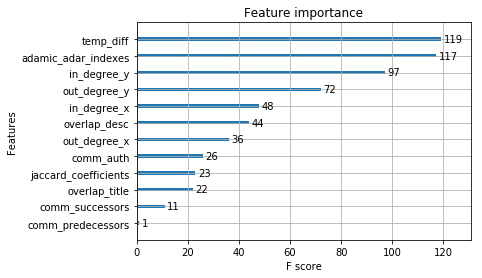

In [26]:
model_classic = XGBClassifier()
model_classic.fit(new_features_train, labels_array)
plot_importance(model_classic)
plt.show()

In [27]:
# Predictions
predictions = model_classic.predict(new_features_test)
df = pd.DataFrame(np.arange(len(new_features_test)), columns=['ID'])
df['category'] = predictions

df.to_csv('new_predictions_10.csv', sep=',', index=False)

# Ensemble model

In [31]:
# Training features
train_features = pd.read_csv("features_train_10.csv", sep=',')

# Labels
# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

# Testing features
test_features = pd.read_csv("features_test_jeudi.csv", sep=',')

In [32]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(train_features, labels_array, test_size=0.33, random_state=42)

### Model 1: XGBClassifier on all features

In [33]:
model_1 = XGBClassifier()
model_1.fit(X_train, y_train)

# Predictions
predictions = model_1.predict(X_test)
df = pd.DataFrame(np.arange(len(X_test)), columns=['ID'])
df['category'] = predictions

# Generate CSV file
df.to_csv('model_1_predictions.csv', sep=',', index=False)

### Model 2: XGBClassifier on selected features

In [34]:
selected_X_train = X_train[['in_degree_x', 'out_degree_x', 'in_degree_y', 'out_degree_y',
                           'comm_successors', 'comm_predecessors', 
                           'overlap_title', 'temp_diff', 'comm_auth', 
                           'adamic_adar_indexes', 'jaccard_coefficients', 'overlap_desc']].copy()
selected_X_test = X_test[['in_degree_x', 'out_degree_x', 'in_degree_y', 'out_degree_y', 
                                   'comm_successors', 'comm_predecessors',
                                  'overlap_title', 'temp_diff', 'comm_auth',
                                   'adamic_adar_indexes', 'jaccard_coefficients', 'overlap_desc']].copy()

In [35]:
model_2 = XGBClassifier()
model_2.fit(selected_X_train, y_train)

# Predictions
predictions = model_2.predict(selected_X_test)
df = pd.DataFrame(np.arange(len(selected_X_test)), columns=['ID'])
df['category'] = predictions

# Generate CSV file
df.to_csv('model_2_predictions.csv', sep=',', index=False)

### Model 3: XgBoost chosen parameters

In [36]:
# XgBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth':10, 'num_class':5, 'eta': 0.3, 'silent': 1, 'objective': 'multi:softmax'}
num_round = 20

# Training the model
model_3 = xgb.train(param, dtrain, num_round)

# Generate predictions
dtest = xgb.DMatrix(X_test)
predictions_3 = model_3.predict(dtest).astype('int')
df = pd.DataFrame(np.arange(len(X_test)), columns=['ID'])
df['category'] = predictions_3

# Generate CSV file
df.to_csv('model_3_predictions.csv', sep=',', index=False)

### Model 4: Random Forest Classifier 

In [37]:
model_4 = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
model_4.fit(X_train, y_train)

# Predictions
predictions_4 = model_4.predict(X_test)
df = pd.DataFrame(np.arange(len(X_test)), columns=['ID'])
df['category'] = predictions_4

# Generate CSV file
df.to_csv('model_4_predictions.csv', sep=',', index=False)

### Model 5: Random Forest Classifier Selected Features

In [38]:
model_5 = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
model_5.fit(selected_X_train, y_train)

# Predictions
predictions_5 = model_5.predict(selected_X_test)
df = pd.DataFrame(np.arange(len(selected_X_test)), columns=['ID'])
df['category'] = predictions_5

# Generate CSV file
df.to_csv('model_5_predictions.csv', sep=',', index=False)

## Ensemble model

In [40]:
results_path = r"C:\Users\Driss Debbagh\Desktop\Cours 3A\NGSA\Assignments\Assignment_2\all\results_train"
results_files = [f for f in listdir(results_path) if isfile(join(results_path, f))]
results_files

['model_1_predictions.csv',
 'model_2_predictions.csv',
 'model_3_predictions.csv',
 'model_4_predictions.csv',
 'model_5_predictions.csv']

In [45]:
results_dataframe = pd.DataFrame()
for i, file in enumerate(results_files):
    csv_dataframe = pd.read_csv("results_train/" + file, sep=',')
    results_dataframe['results' + str(i)] = csv_dataframe['category']

results_dataframe.head()

,results0,results1,results2,results3,results4
0,1,1,1,1,1
1,0,0,0,0,0
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


In [47]:
results_dataframe.describe()

,results0,results1,results2,results3,results4
count,20312.000000,20312.000000,20312.000000,20312.000000,20312.000000
mean,0.527668,0.528210,0.530032,0.522597,0.520136
std,0.499246,0.499216,0.499110,0.499501,0.499607
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## Simple classification model

In [57]:
# Logistic regression
ensemble_model = sm.Logit(y_test, results_dataframe)

# fit the model
result = ensemble_model.fit()

Optimization terminated successfully.
         Current function value: 0.365001
         Iterations 8


In [58]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                20312
Model:                          Logit   Df Residuals:                    20307
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Jan 2019   Pseudo R-squ.:                  0.4706
Time:                        11:54:15   Log-Likelihood:                -7413.9
converged:                       True   LL-Null:                       -14004.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
results0       1.8485      0.551      3.353      0.001       0.768       2.929
results1       0.0663      0.527      0.126      0.900      -0.966       1.099
results2       1.1847      0.218      5.433      0.000       0.757       1.612
results3      -1.0876      0.275     -3.948      0.000      -1.628      -0.548
results4       2.2806      0.363      6.282      0.000       1.569       2.992
==============================================================================
"""

In [54]:
result.conf_int()

,0,1
results1,1.042700,2.174638
results2,0.846032,1.698703
results3,-1.637929,-0.564874
results4,1.818885,3.191820


In [60]:
ensemble_model_2 = LogisticRegression().fit(results_dataframe, y_test)
# ensemble_model_2.predict()
ensemble_model_2.coef_ 

C:\Users\Driss Debbagh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[1.45658486, 0.96159482, 3.22260974, 1.371922  , 0.6119    ]])

In [69]:
predictions_model_1 = model_1.predict(test_features)

predictions_model_2 = model_2.predict(new_features_test)

dtest = xgb.DMatrix(test_features)
predictions_model_3 = model_3.predict(dtest).astype('int')

predictions_model_4 = model_4.predict(test_features)

predictions_model_5 = model_5.predict(new_features_test)

all_predictions = [predictions_model_1, predictions_model_2, predictions_model_3, predictions_model_4, predictions_model_5]

In [70]:
last_dataframe = pd.DataFrame()
for i in range(5):
    last_dataframe['results' + str(i)] = all_predictions[i]
last_dataframe.head()

,results0,results1,results2,results3,results4
0,0,0,0,0,0
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,0,0,1,0,1


In [71]:
# Predictions
last_predictions = ensemble_model_2.predict(last_dataframe)
df = pd.DataFrame(np.arange(len(test_features)), columns=['ID'])
df['category'] = last_predictions

# Generate CSV file
df.to_csv('model_ensemble_predictions.csv', sep=',', index=False)